### Reference :: <https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55>

In [1]:
import cv2
import os
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import patches
import xml.etree.ElementTree as ET

%matplotlib inline

In [2]:
# Using Oxfold Pet Dataset
DATA_ROOT = os.path.abspath('./data')
ANN_DIR = os.path.join(DATA_ROOT, 'annotations/xmls')
IMG_DIR = os.path.join(DATA_ROOT, 'images')

annotations = sorted(os.listdir(ANN_DIR))

In [3]:
def GetImageInformation(ann_file):
    # Read annotation file(*.xml)
    tree = ET.parse(os.path.join(ANN_DIR, ann_file))
  
    root = tree.getroot()
    
    # Image Load
    image_file = root.findall('filename')[0].text
    img = cv2.imread(os.path.join(IMG_DIR, image_file))

    # Get Ground Truth Information
    x1 = int(root.find('object').find('bndbox').find('xmin').text)
    y1 = int(root.find('object').find('bndbox').find('ymin').text)
    x2 = int(root.find('object').find('bndbox').find('xmax').text)
    y2 = int(root.find('object').find('bndbox').find('ymax').text)

    gt_bbox = np.array([x1, y1, x2-x1, y2-y1])
    
    obj_name = root.find('object').find('name').text
    
    return img, gt_bbox, obj_name

In [4]:
def SelectiveSearch(img):
    # Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    print('Proposed Region :: {}'.format(len(ssresults)))
    
    return ssresults

In [5]:
def ComputeIOU(gt, p):
    x1 = np.maximum(gt[0], p[:, 0])
    y1 = np.maximum(gt[1], p[:, 1])
    x2 = np.minimum(gt[0] + gt[2], p[:, 0] + p[:, 2])
    y2 = np.minimum(gt[1] + gt[3], p[:, 1] + p[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    gt_area = gt[2] * gt[3]
    propoesed_area = p[:, 2] * p[:, 3]
    union = gt_area + propoesed_area[:] - intersection[:]

    iou = intersection/union
    
    return iou

In [10]:
def GenerateFinalRegion(gt_bbox, rp):
    # Generate pos, neg region
    iou_results = ComputeIOU(gt_bbox, rp)
    
    positive = np.array([], dtype=np.int32).reshape(0, 4)
    negative = np.array([], dtype=np.int32).reshape(0, 4)
   
    pos_cnt = 0
    neg_cnt = 0
       
    for idx, iou in enumerate(iou_results):
        if idx < 2000:
            # positive
            if iou > 0.7 and pos_cnt <= 30:
                positive = np.vstack([positive, rp[idx]])
                pos_cnt += 1

            # negative
            elif iou < 0.3 and neg_cnt <= 30:
                negative = np.vstack([negative, rp[idx]])
                neg_cnt += 1
        else:
            break
    
    return positive, negative

In [109]:
def DrawRegion(bboxes, title='Empty', color='magenta', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
    
    # BBox Display
    for bbox in bboxes:
        x, y, w, h = bbox
        p = patches.Rectangle((x, y), w, h, linewidth=2, alpha=1.0, linestyle="solid", edgecolor=color, facecolor='none')
        ax.add_patch(p)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(title)


In [141]:
def VisualizeRegion(img, rp):
    imgs = []

    for i in rp:
        x, y, w, h = i
        roi_img = img[y:y+h, x:x+w]
        re_img = cv2.resize(roi_img, (224,224), interpolation = cv2.INTER_AREA)
        imgs.append(re_img)

    rows = 3
    cols = 3
    length = rows * cols

    if len(imgs) != 0 and len(imgs) < length:
        length = len(imgs)
        rows = 1
        cols = len(imgs)

    fig = plt.figure(figsize=(10, 10))

    for i in range(length):
        plt.subplot(rows, cols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        new_img = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
    plt.tight_layout()
    

In [142]:
# ann_file = 'havanese_167.xml'
ann_file = random.choice(annotations)

img, gt_bbox, obj_name = GetImageInformation(ann_file)
print('Category Name :: {}'.format(obj_name))

rp = SelectiveSearch(img)
pos, neg = GenerateFinalRegion(gt_bbox, rp)


Category Name :: dog
Proposed Region :: 849


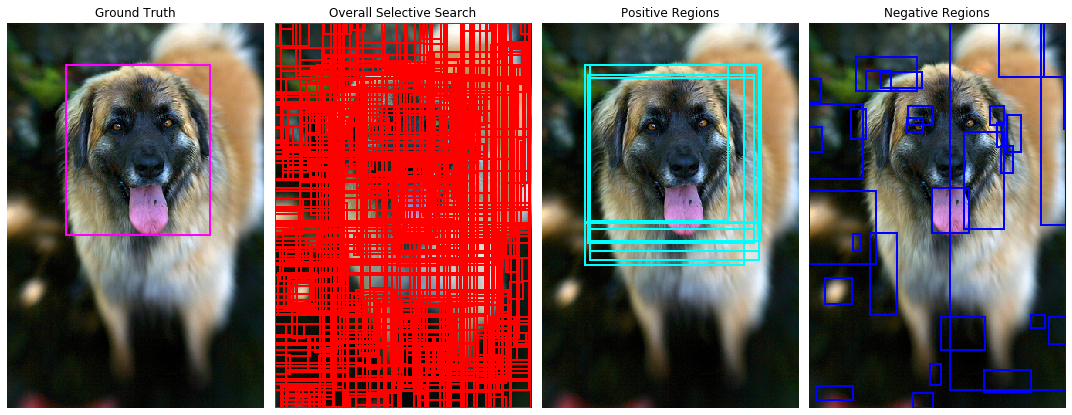

In [143]:
_, ax = plt.subplots(1, 4, figsize=(15, 15))

# Display Ground Truth
DrawRegion(np.array([gt_bbox]), title='Ground Truth', ax=ax[0])

# Display Overall Selective Search
DrawRegion(rp, title='Overall Selective Search', color='red', ax=ax[1])

# Display Positive Region
DrawRegion(pos, title='Positive Regions',  color='cyan', ax=ax[2])

# Display Negitive Region
DrawRegion(neg, title='Negative Regions', color='blue', ax=ax[3])

plt.tight_layout()

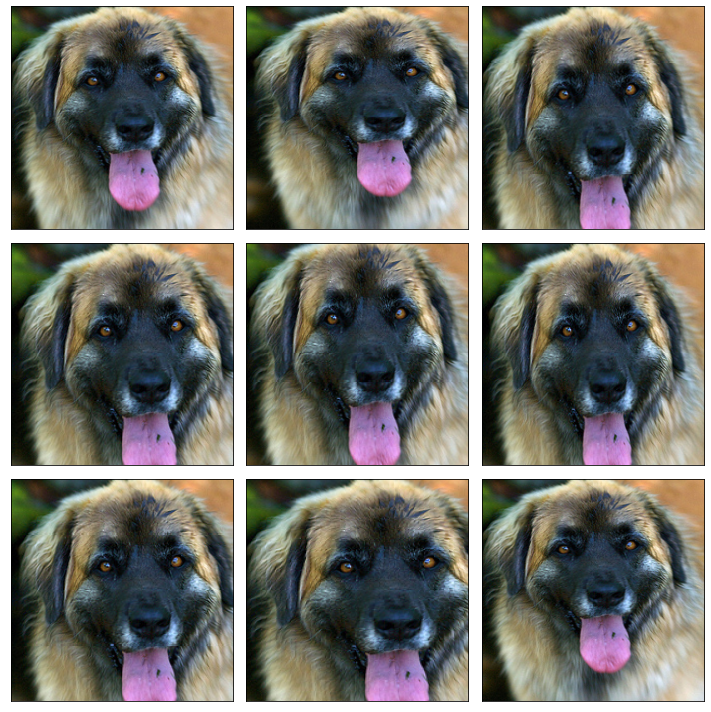

In [144]:
# Visualize Positive Region
VisualizeRegion(img, pos)

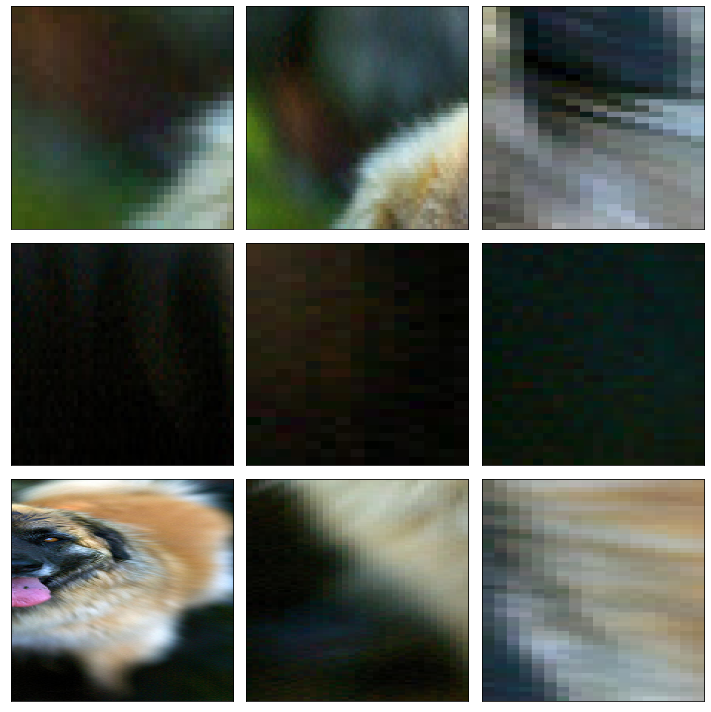

In [145]:
# Visualize Negative Region
VisualizeRegion(img, neg)